# Coursera Capostone project - Andrea Tamburri
## Reccomender system of clustered cities in the U.S.

### The purpose of thi Jupyter notebook is to show you how to implement a content-based recommender system, based on clustered cities for venue distribution in the U.S.
### Knowing which are the similar cities and what a customer likes, we can recommend cities to visit that are the most interesting for the customer

In [200]:
!conda install -c conda-forge folium --yes
#!conda install -c conda-forge geopy --yes 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTAL

In [202]:
import numpy as np
import pandas as pd

#libraries to interact with API and scrape
import requests
import json


import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage + metrics for elbow evaluation
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist


print('Libraries imported.')

Libraries imported.


# Data importing
## Data about cities geolocation and population have been imported from https://simplemaps.com/data/world-cities

In [2]:
# The code was removed by Watson Studio for sharing.

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [3]:
# We'll take just the top 30 most populated Cities, so in this case it's useless to take out missing values, given that preprocessing part
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493 entries, 0 to 15492
Data columns (total 11 columns):
city          15493 non-null object
city_ascii    15493 non-null object
lat           15493 non-null float64
lng           15493 non-null float64
country       15493 non-null object
iso2          15462 non-null object
iso3          15493 non-null object
admin_name    15302 non-null object
capital       5246 non-null object
population    13808 non-null float64
id            15493 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.3+ MB


##### Data about customer reviews and venues location have been imported from Kaggle at https://www.kaggle.com/yelp-dataset/yelp-dataset
### This consists on two datasets from https://www.yelp.it :
##### 1. yelp_academic_dataset_review.json (of "just" 5M records, for making it simple to work on this project) that contains information about the customer who reviews, the stars of rating and the business that has been reviewed plus other information, not necessary in this project
##### 2. yelp_academic_dataset_business.json, a dataset containing infromation about the id of the business, the name of it and its city, really important in order to connect to the cities table


In [4]:
# The code was removed by Watson Studio for sharing.

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


##### As you will see below, this table contains as well ratings of businesses, but it's an overall rating. We need customer rating in order to create the user's profile for the content-based recommender system

In [5]:
# importing businesses table
body = client_79b0951f4f834ed682d43122677089c4.get_object(Bucket='ibmdatasciencespecializationcapst-donotdelete-pr-tohyvn7jmesz26',Key='yelp_academic_dataset_business.json')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object 

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face an error during data loading.
# Please read the documentation of 'pandas.read_json()' and 'pandas.io.json.json_normalize' to learn more about the possibilities to adjust the data loading.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html#io-json-reader
# and http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html

df_businesses = pd.read_json(body, orient='values', lines = True)
df_businesses.business_id.astype(str)
df_businesses.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
address         192609 non-null object
attributes      163773 non-null object
business_id     192609 non-null object
categories      192127 non-null object
city            192609 non-null object
hours           147779 non-null object
is_open         192609 non-null int64
latitude        192609 non-null float64
longitude       192609 non-null float64
name            192609 non-null object
postal_code     192609 non-null object
review_count    192609 non-null int64
stars           192609 non-null float64
state           192609 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


# Data preprocessing

##  Reviews table cleaning and preprocessing
### Let's clean the record with null reviews velues.  After that We'll group by customer - city in order to obtain a mean rating for cities that he already visited
### In this way, We're exploiting venues rating in order to "predict", with a simple mean, a rating for the city as a whole. This is fundamental during the creation of the user's profile

In [6]:
df_businesses_reviews = df_reviews.merge(df_businesses, how='inner', left_on='business_id',right_on='business_id')
df_businesses_reviews.head()

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,...,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars_y,state
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA,3100 N Tenaya Way,...,Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.215546,-115.248798,MountainView Hospital,89128,238,2.5,NV
1,ujmEBvifdJM6h6RLv4wQIg,0,2017-02-09 06:45:18,0,8Edv5pKe5lOBoN5UZTUI1w,4,My family has used this ER four times in the p...,0,RBXSJA372ilErzNwz0jXvQ,3100 N Tenaya Way,...,Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.215546,-115.248798,MountainView Hospital,89128,238,2.5,NV
2,ujmEBvifdJM6h6RLv4wQIg,0,2018-08-14 05:25:33,0,kEs5u0cGPtiSQCLW7b0l9g,1,I have never been more disappointed by the car...,1,x3brMMbJrAW9PwW5A6YL5w,3100 N Tenaya Way,...,Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.215546,-115.248798,MountainView Hospital,89128,238,2.5,NV
3,ujmEBvifdJM6h6RLv4wQIg,0,2018-05-08 19:27:59,0,Pm6qydbW58BB0zdWCPlBmg,1,"Went in for a broken finger, was asked if I wa...",3,Skzdl0sWhW88525a1vr59g,3100 N Tenaya Way,...,Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.215546,-115.248798,MountainView Hospital,89128,238,2.5,NV
4,ujmEBvifdJM6h6RLv4wQIg,0,2014-10-11 06:57:18,0,QWJVYwNxUY_Plu4Ipz33_A,5,My mother was at Mountain View for nearly two ...,1,3Y25VDfnQVcuc33T-U3Z6A,3100 N Tenaya Way,...,Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.215546,-115.248798,MountainView Hospital,89128,238,2.5,NV


In [7]:
# taking just the columns that we need, NB. given that both tables have column stars, but we need the ratigns of users
# we'll take stars_x
colnames = ['user_id','city','stars_x']
#df_businesses_reviews.groupby(['user_id','city'])
df_businesses_reviews = df_businesses_reviews[colnames]
df_businesses_reviews.head()

,user_id,city,stars_x
0,hG7b0MtEbXx5QzbzE6C_VA,Las Vegas,1
1,RBXSJA372ilErzNwz0jXvQ,Las Vegas,4
2,x3brMMbJrAW9PwW5A6YL5w,Las Vegas,1
3,Skzdl0sWhW88525a1vr59g,Las Vegas,1
4,3Y25VDfnQVcuc33T-U3Z6A,Las Vegas,5


In [8]:
# now we're grouping for users and city, in order to get an average rating for that user in that city
# this is the rating on a user for a particular city
#removing hierarchial indexing created by grouping
df_businesses_reviews_grouped = df_businesses_reviews.groupby(['user_id','city']).mean()
df_businesses_reviews_grouped.reset_index(inplace=True)
df_businesses_reviews_grouped.head()

,user_id,city,stars_x
0,---1lKK3aKOuomHnwAkAow,Henderson,3.666667
1,---1lKK3aKOuomHnwAkAow,Las Vegas,3.934211
2,---1lKK3aKOuomHnwAkAow,North Las Vegas,3.666667
3,---94vtJ_5o_nikEs6hUjg,Phoenix,5.000000
4,---PLwSf5gKdIoVnyRHgBA,Phoenix,5.000000


In [9]:
# number of cities
cities = df_businesses_reviews_grouped.city.unique()
print(len(cities))

1080


In [10]:
# number of users
print(len(df_businesses_reviews_grouped.user_id.unique()))

1394461


## Cities Table
### We'll take the top 30 U.S.  cities in the scraped Yielp dataset in order to build a prototype of our reccommender system

In [11]:
#let's take the cities that match with the ones in the Yelp dataset

df_top_cities = df_cities[df_cities['city'].isin(cities)]
df_top_cities = df_top_cities[df_top_cities['country']=='United States']
df_top_cities.sort_values(by = ['population'], ascending=False, inplace=True)
df_top_cities.reset_index(drop=True, inplace=True)
df_top_cities = df_top_cities.head(30)
df_top_cities

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
1,Los Angeles,Los Angeles,34.1139,-118.4068,United States,US,USA,California,NaN,12815475.0,1840020491
2,Dallas,Dallas,32.7936,-96.7662,United States,US,USA,Texas,NaN,5733259.0,1840019440
3,Phoenix,Phoenix,33.5722,-112.0891,United States,US,USA,Arizona,admin,4081849.0,1840020568
4,Seattle,Seattle,47.6211,-122.3244,United States,US,USA,Washington,NaN,3643765.0,1840021117
5,San Diego,San Diego,32.8312,-117.1225,United States,US,USA,California,NaN,3210314.0,1840021990
6,Denver,Denver,39.7621,-104.8759,United States,US,USA,Colorado,admin,2787266.0,1840018789
7,Brooklyn,Brooklyn,40.6501,-73.9496,United States,US,USA,New York,NaN,2629150.0,1840034030
8,Las Vegas,Las Vegas,36.2333,-115.2654,United States,US,USA,Nevada,NaN,2073045.0,1840020364
9,Cleveland,Cleveland,41.4767,-81.6805,United States,US,USA,Ohio,NaN,1730363.0,1840000596


In [12]:
#we'll just take the interesting columns
colnames = ['city', 'lat', 'lng', 'country']
df_top_cities = df_top_cities[colnames]
df_top_cities.head()

,city,lat,lng,country
0,New York,40.6943,-73.9249,United States
1,Los Angeles,34.1139,-118.4068,United States
2,Dallas,32.7936,-96.7662,United States
3,Phoenix,33.5722,-112.0891,United States
4,Seattle,47.6211,-122.3244,United States


In [13]:
#no missing values
df_top_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
city       30 non-null object
lat        30 non-null float64
lng        30 non-null float64
country    30 non-null object
dtypes: float64(2), object(2)
memory usage: 1.0+ KB


## Importing data from Foursquare
### We'll use the same techniques showe in the lab about Foursquare

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
#in this case I have to define a radius given that I'm gonna exceed daily limits for this API call

def getNearbyVenues(names, latitudes, longitudes, radius = 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
            
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, -
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#I'll put a limit given that I'm gonna exceed API request limit
CLIENT_ID='S0JIXQ4C0JNAMTQACUOATZZ2BFUG3BUNLT23ZQMLRRUG15KO'
CLIENT_SECRET='LML20BYLN1TLKRBWMKKNGJS30I2VSAOOKIP1K2PRZLAXNFD3'
VERSION='20180323'
LIMIT = 650 
rad = 1200
city_venues = getNearbyVenues(names=df_top_cities['city'],
                                   latitudes=df_top_cities['lat'],
                                   longitudes=df_top_cities['lng'],
                                   radius = rad
                                  )

New York
Los Angeles
Dallas
Phoenix
Seattle
San Diego
Denver
Brooklyn
Las Vegas
Cleveland
Pittsburgh
Columbus
Charlotte
Omaha
Allentown
Concord
Ogden
Akron
Mesa
Harrisburg
Madison
Oakland
Lancaster
Aurora
Lancaster
Greensboro
Antioch
Henderson
Peoria
Columbus


In [17]:
# I have to raise limit and radius
city_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Akron,75,75,75,75,75,75
Allentown,50,50,50,50,50,50
Antioch,23,23,23,23,23,23
Aurora,3,3,3,3,3,3
Brooklyn,100,100,100,100,100,100
Charlotte,100,100,100,100,100,100
Cleveland,56,56,56,56,56,56
Columbus,25,25,25,25,25,25
Concord,50,50,50,50,50,50


#### We'll do some preprocessing now, given that K-mean doen't work with catregorical variables; I'll do one hot econding
#### After that I'll group by city in order to obtain a frequancy distribution of the venues for each city

In [18]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add Borough column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move Borough column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]


city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Akron,0.0,0.0,0.0,0.026667,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.013333,0.00,0.00,0.0,0.00
1,Allentown,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.020000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.00
2,Antioch,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,...,0.00,0.043478,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.00
3,Aurora,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.00
4,Brooklyn,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.01,0.000000,0.0,0.0,0.0,0.000000,0.02,0.01,0.0,0.01


### After joining the two dataframes by the business_id of the venue, and grouping them we can clearly see how many users we have and how many cities we have

# Data Visualization

## Let's see the most frequent venues for each City

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [99]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['city'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Akron,Sandwich Place,Bar,Café,Italian Restaurant,Bank
1,Allentown,Sandwich Place,Coffee Shop,Mexican Restaurant,Brewery,Gastropub
2,Antioch,Chinese Restaurant,Pharmacy,Intersection,Sports Bar,Sandwich Place
3,Aurora,Farm,Cosmetics Shop,Pet Store,Fish Market,Farmers Market
4,Brooklyn,Caribbean Restaurant,Pizza Place,Café,Mobile Phone Shop,Bakery
5,Charlotte,Pizza Place,Coffee Shop,Gym / Fitness Center,Sandwich Place,Park
6,Cleveland,Bar,Pub,Coffee Shop,Intersection,Convenience Store
7,Columbus,Fast Food Restaurant,Intersection,Fried Chicken Joint,Food Truck,Flower Shop
8,Concord,Pizza Place,Sandwich Place,Convenience Store,American Restaurant,Hotel
9,Dallas,Mexican Restaurant,Convenience Store,Pizza Place,Dive Bar,Dance Studio


### We're going to plot the average rating for each city, in order to "predict" which cities are most likely to be recommended, given that the entire system is based on recommending the the clusters with the best rating for each user

In [21]:
# calculating the average for each city in the DataFrame
df_city_ratings = df_businesses_reviews_grouped[['city','stars_x']]
df_city_ratings = df_city_ratings.groupby(['city']).mean()
df_city_ratings.reset_index(inplace=True)

#Joining with the top30 cities to cluster
top30_city = df_top_cities['city']
df_city_ratings = df_city_ratings.merge(top30_city, how='inner', left_on='city',right_on='city')
#df_city_ratings.drop('ity',axis=1,inplace=True)
df_city_ratings.set_index('city',inplace=True)
df_city_ratings['stars_x'] = pd.to_numeric(df_city_ratings['stars_x'], downcast="float")
df_city_ratings = df_city_ratings['stars_x']  #creating a series to better deal with pyplot
df_city_ratings.drop_duplicates(keep='first',inplace=True)
df_city_ratings.head

<bound method NDFrame.head of city
Akron          3.691662
Allentown      3.789474
Antioch        2.545455
Aurora         3.413033
Brooklyn       3.354504
Charlotte      3.570503
Cleveland      3.631120
Columbus       4.606061
Concord        3.491537
Dallas         4.094809
Denver         3.520549
Greensboro     4.000000
Harrisburg     3.700659
Henderson      3.813601
Lancaster      3.600000
Las Vegas      3.714993
Los Angeles    4.441861
Madison        3.692784
Mesa           3.710344
New York       4.235294
Oakland        3.250000
Ogden          3.397850
Omaha          1.875000
Peoria         3.571773
Phoenix        3.705567
Pittsburgh     3.665864
San Diego      1.371429
Seattle        5.000000
Name: stars_x, dtype: float32>

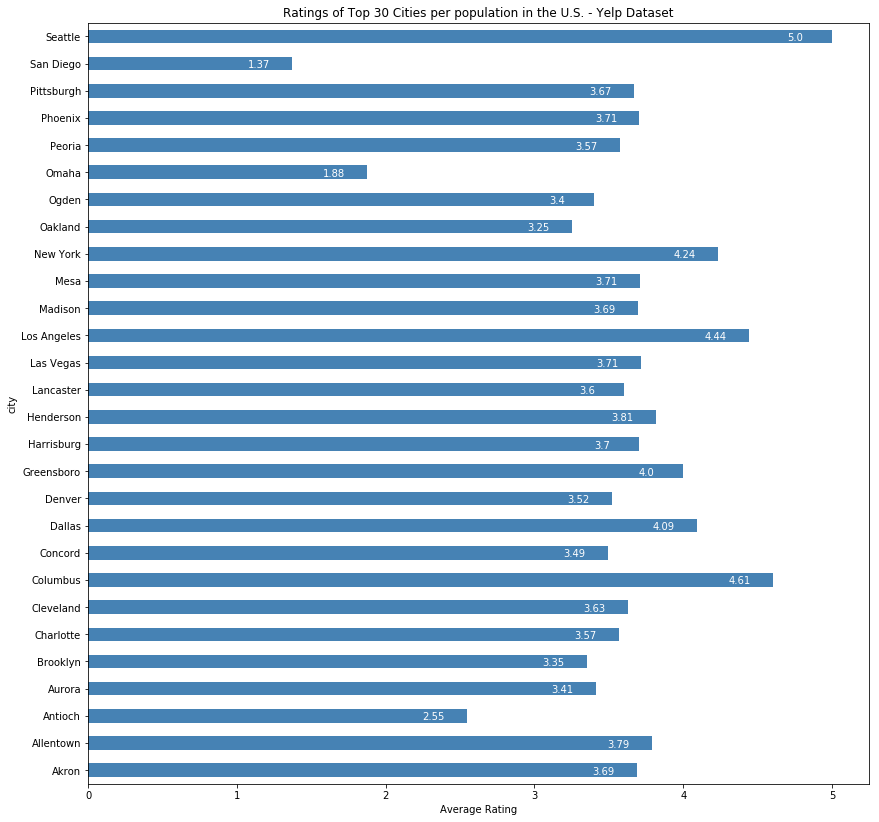

In [22]:
#let's plot the results

df_city_ratings.plot(kind='barh', figsize=(14, 14), color='steelblue')
plt.xlabel('Average Rating')
plt.title('Ratings of Top 30 Cities per population in the U.S. - Yelp Dataset')


 # annotate value labels to each country
for index, value in enumerate(df_city_ratings): 
    label = round(value,2) # format int with commas
    
    # place text at the end of bar (subtracting 0.5 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value-0.3, index - 0.15), color='white')

### Let's see which are the most reviewd cities among the 30s

In [23]:
# calculating the count of ratings for each city in the DataFrame
city_ratings_count = df_businesses_reviews_grouped[['city','user_id']]
city_ratings_count = city_ratings_count[city_ratings_count.city.isin(top30_city)]
city_ratings_count = city_ratings_count['city'].value_counts()
city_ratings_count

Las Vegas      521481
Phoenix        212617
Charlotte       80122
Henderson       75643
Mesa            64919
Pittsburgh      57578
Cleveland       35606
Madison         27296
Peoria          24543
Concord          8387
Akron            4355
Aurora           2310
Dallas           1166
Brooklyn         1071
Harrisburg        887
Denver            741
Los Angeles        43
San Diego          35
Columbus           33
Ogden              31
Allentown          19
New York           17
Oakland            12
Antioch            11
Omaha               8
Lancaster           5
Greensboro          4
Seattle             3
Name: city, dtype: int64

In [24]:
#Let's create a pie chart of the top 3 cities vs the rest
top3_city_ratings_count = city_ratings_count.head(3)
other_city_ratings_count = city_ratings_count.tail(27)
other = pd.Series(other_city_ratings_count.sum(),index=['other'])
city_ratings_count_v2 = top3_city_ratings_count.append(other)
city_ratings_count_v2

Las Vegas    521481
Phoenix      212617
Charlotte     80122
other        597462
dtype: int64

Text(0.5, 1.0, 'Percentage of number of revies per City')

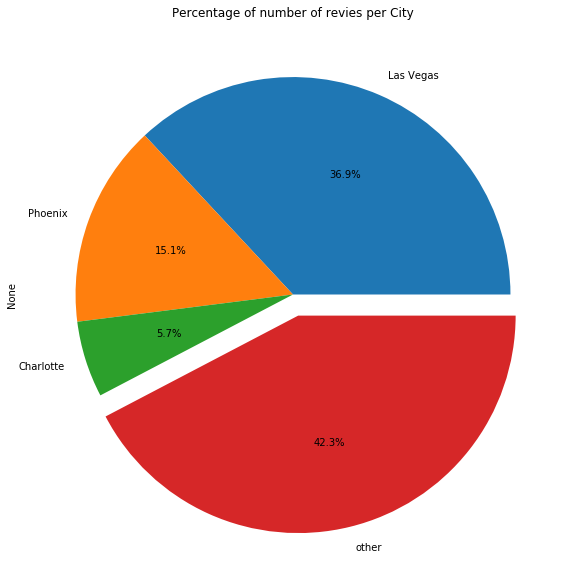

In [25]:
city_ratings_count_v2.plot(kind='pie', figsize=(10, 10), autopct='%1.1f%%', explode=(0,0,0,0.1))
plt.title('Percentage of number of revies per City')

### As we can see above, Seattle, that has 5 of average rating, has only 3 reviews! It could be interesting to see if there's correlation between the number of revies and the average rating

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



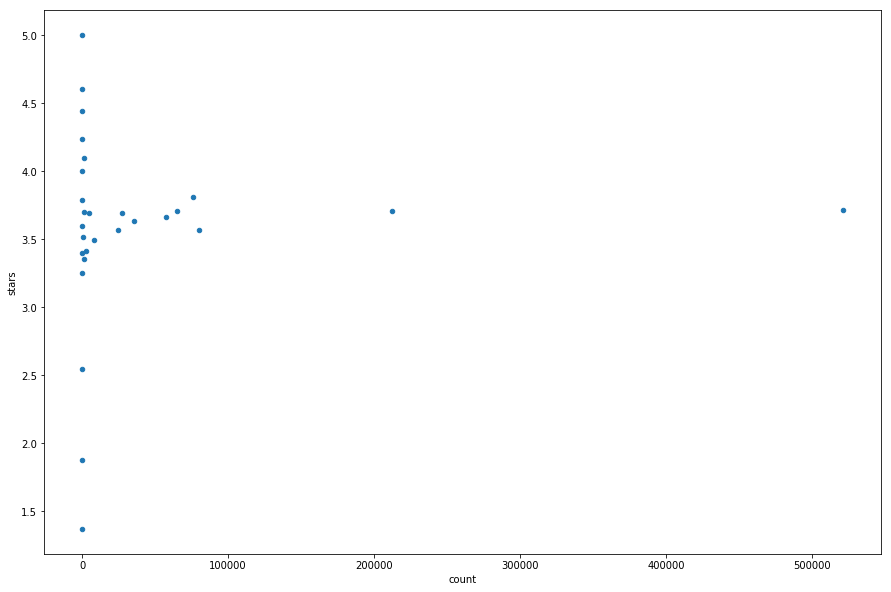

In [26]:
#let's create a DataFrame containing the avg rating and the rating count for each city
colnames = ['count','stars']

city_ratings_count_avg = pd.concat([city_ratings_count,df_city_ratings], axis=1)
city_ratings_count_avg.columns = colnames
city_ratings_count_avg.plot.scatter(x='count',y='stars',figsize=(15, 10))

### There's no correlation between those two metrics, maybe because we have not enough data

# Clustering of city by venues distirbution
## The next step is to cluster the city that we scraped into the df_cities, in order to create the cluster matrix of the content-based recommender system
### I'll use the elbow method in order to find the optimal number of clusters

In [95]:
#I'm calculating by hand in order to plot them easily, but I'm wìswhowing the built-in functions as well
city_grouped_clustering = city_grouped.drop('City', 1)
K=25

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {}
mapping = {}
  
for k in range(1,K): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(city_grouped_clustering) 
    kmeanModel.fit(city_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(city_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / city_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(city_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / city_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    mapping[k] = (mapping1[k],mapping2[k])
    
    
for key, metric in mapping.items():
    print('\n')
    print('Distorsion '+str(key)+' : '+str(metric[0]) + '   Inertia '+str(key)+' : '+str(metric[1]))



Distorsion 1 : 0.20108433107205112   Inertia 1 : 1.465651213441148


Distorsion 2 : 0.1799137306875944   Inertia 2 : 1.1393157053323038


Distorsion 3 : 0.1611315847594959   Inertia 3 : 0.8364133189916472


Distorsion 4 : 0.147154928440107   Inertia 4 : 0.6930153200521204


Distorsion 5 : 0.13848546906939466   Inertia 5 : 0.6368108085303977


Distorsion 6 : 0.13251484717056364   Inertia 6 : 0.5818610518665382


Distorsion 7 : 0.11685530587873329   Inertia 7 : 0.4845921550880792


Distorsion 8 : 0.10968702209014371   Inertia 8 : 0.4490215185385338


Distorsion 9 : 0.10002431774591174   Inertia 9 : 0.40764724137665753


Distorsion 10 : 0.09570889948606849   Inertia 10 : 0.3748792496574668


Distorsion 11 : 0.08887213199184711   Inertia 11 : 0.3380791492658549


Distorsion 12 : 0.08428542455323529   Inertia 12 : 0.30395038223097226


Distorsion 13 : 0.0775404924557483   Inertia 13 : 0.288264056586645


Distorsion 14 : 0.06955629981090487   Inertia 14 : 0.24402849719213932


Distorsion 1

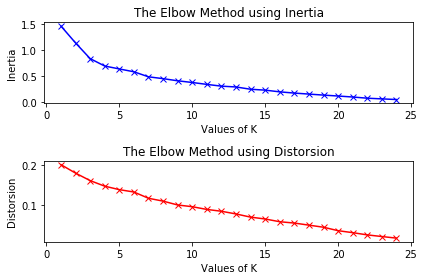

In [96]:
figure, axes = plt.subplots(nrows=2)

axes[0].plot(range(1,K), inertias, 'bx-')
axes[0].set_xlabel('Values of K') 
axes[0].set_ylabel('Inertia') 
axes[0].set_title('The Elbow Method using Inertia') 


axes[1].plot(range(1,K), distortions, 'rx-') 
axes[1].set_xlabel('Values of K') 
axes[1].set_ylabel('Distorsion') 
axes[1].set_title('The Elbow Method using Distorsion') 

figure.tight_layout()
figure.show()

### Since the result is a bit ambigous (there's a elbow using Inertia at K=3, but there's no strong evidence) I'll use a K=6, also because it's better to have more cluster for our recommender system, in order to be more accurate on the recommendation

In [97]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 3, 3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 0, 5, 0, 4, 1, 0, 3, 0],
      dtype=int32)

In [100]:
# add clustering labels
city_venues_sorted2 = city_venues_sorted
city_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)
city_merged = df_top_cities
city_merged

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted2.set_index('city'), on='city')

city_merged.head()

,city,lat,lng,country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,New York,40.6943,-73.9249,United States,0,Bar,Coffee Shop,Mexican Restaurant,Pizza Place,Bakery
1,Los Angeles,34.1139,-118.4068,United States,1,Park,Scenic Lookout,Trail,Home Service,Lake
2,Dallas,32.7936,-96.7662,United States,3,Mexican Restaurant,Convenience Store,Pizza Place,Dive Bar,Dance Studio
3,Phoenix,33.5722,-112.0891,United States,3,Fast Food Restaurant,Convenience Store,Mexican Restaurant,Nail Salon,Sandwich Place
4,Seattle,47.6211,-122.3244,United States,0,Coffee Shop,Bar,Cocktail Bar,Café,Yoga Studio


### Let's visualize the entire map of U.S. with the city clustered

In [204]:
# create map
# let's set U.S. latitude and longitude 
us_latitude = 37.0902405
us_longitude = -95.7128906

map_clusters = folium.Map(location=[us_latitude, us_longitude])

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(city_merged['lat'], city_merged['lng'], city_merged['city'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now let's see the discriminants of each cluster

In [101]:
#Using the same approach as for each borough
city_onehot_cluster = city_onehot
city_cluster = city_merged[['city','Cluster Labels']]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_onehot_cluster = city_onehot_cluster.merge(city_cluster, how='inner', left_on='City', right_on='city')
city_onehot_cluster.drop('city',inplace=True,axis=1)

city_grouped_cluster = city_onehot_cluster.groupby('Cluster Labels').mean().reset_index()


# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
clusters_venues_sorted = pd.DataFrame(columns=columns)
clusters_venues_sorted['Cluster Labels'] = city_grouped_cluster['Cluster Labels']

for ind in np.arange(city_grouped_cluster.shape[0]):
    clusters_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped_cluster.iloc[ind, :], num_top_venues)

clusters_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Bar,Coffee Shop,Café,American Restaurant,Sandwich Place
1,1,Park,Scenic Lookout,Trail,Home Service,Lake
2,2,Farm,Cosmetics Shop,Pet Store,Fish Market,Farmers Market
3,3,Pizza Place,Sandwich Place,Mexican Restaurant,Coffee Shop,Fast Food Restaurant
4,4,Park,Moving Target,Trail,Food,Home Service
5,5,Other Repair Shop,Auto Workshop,Auto Garage,Trail,Video Store


### Let's plot a pie chart describing the proportion of each cluster

In [102]:
#merging a df, city_cluster, with a pandas series, city_ratings_count

#creating a dataframe from a pandas series
frame = { 'city': city_ratings_count.index, 'count': city_ratings_count.values }
df_city_ratings_count = pd.DataFrame(frame)

#joining the two dfs
city_cluster_count = city_cluster.merge(df_city_ratings_count, how='inner', left_on='city',right_on='city')
city_cluster_count.drop('city',axis=1,inplace=True)
city_cluster_count.head()

,Cluster Labels,count
0,0,17
1,1,43
2,3,1166
3,3,212617
4,0,3


In [103]:
#create a df containing all the ratings counts for each df

cluster_count =  city_cluster_count.groupby(['Cluster Labels']).sum()
cluster_count = cluster_count['count']
cluster_count

Cluster Labels
0     68213
1        43
2      2310
3    451291
4    521481
5     75643
Name: count, dtype: int64

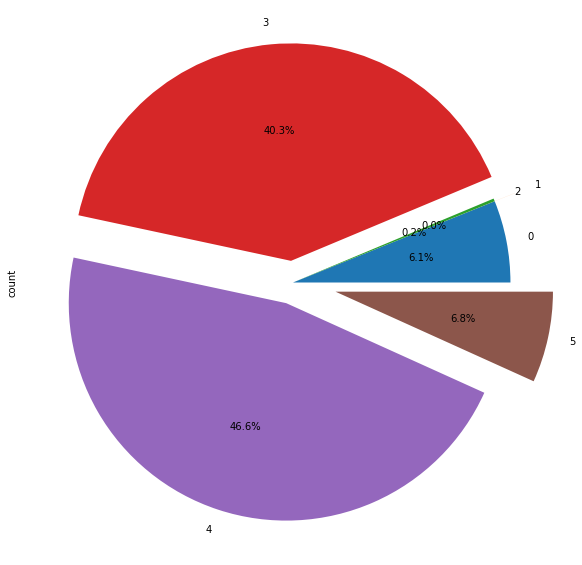

In [109]:
cluster_count.plot(kind='pie', figsize=(10, 10), autopct='%1.1f%%', explode=(0,0.1,0,0.1,0.1,0.2))

### As we can see, cluster 1 and 2 are really few of ratings, but we'll keep them as we saw that are different from the other ones. That reflects the distribution of the city ratings we saw.

# Content-based Recommender System

### The first step for creating our content based recommender system is to create the user's profile, a brief description of "how much a consumer likes a cluster"

In [196]:
#let's create a df of the users' profiles, containing one record for one combination of user cluster
#as you can see from the head, there're not so many information of each cluster for each consumer, that means that, in order to apply in reality this project, this need to be scaled up, in order to have tons and tons of data
#summing over user and cluster, let us measuer how much a consumer liked a cluster by the quality of the rating (how, on average, he liked the cluster, and how many times he reviewd a cluster): so, the more he reviewd a cluster, and the more the rating was high,
#the more the cluster will be in a igher recommendation place for that user
#NB. Since here we clustered just 30 cities (and with just one sample of clustering), the procedure could be unreliable, but this is just a project run in a small cluster

df_user_profile = df_businesses_reviews_grouped.join(city_cluster.set_index('city'),on='city')
df_user_profile.drop('city',axis=1,inplace=True)

#let's take an user as sample
df_user_profile[df_user_profile['user_id']=='2LaXC_AW4I0EBU9FhzpOgg'] 

,user_id,stars_x,Cluster Labels
107926,2LaXC_AW4I0EBU9FhzpOgg,3.500000,2.0
107927,2LaXC_AW4I0EBU9FhzpOgg,4.500000,NaN
107928,2LaXC_AW4I0EBU9FhzpOgg,4.000000,NaN
107929,2LaXC_AW4I0EBU9FhzpOgg,2.000000,NaN
107930,2LaXC_AW4I0EBU9FhzpOgg,4.333333,0.0
107931,2LaXC_AW4I0EBU9FhzpOgg,4.000000,NaN
107932,2LaXC_AW4I0EBU9FhzpOgg,4.250000,NaN
107933,2LaXC_AW4I0EBU9FhzpOgg,4.500000,5.0
107934,2LaXC_AW4I0EBU9FhzpOgg,2.333333,NaN
107935,2LaXC_AW4I0EBU9FhzpOgg,5.000000,NaN


In [197]:
#let's clean from the nan values (NB. Of course this is a project run in a small cluster, it'd be really interesting to cluster all the cities mapped here as well as add more clustring, in order to have a real world project use case)
df_user_profile.dropna(inplace=True)
df_user_profile = df_user_profile.groupby(['user_id','Cluster Labels']).sum()
df_user_profile.reset_index(inplace=True)


In [198]:
df_user_profile[df_user_profile['user_id']=='2LaXC_AW4I0EBU9FhzpOgg'] 

,user_id,Cluster Labels,stars_x
56291,2LaXC_AW4I0EBU9FhzpOgg,0.0,4.333333
56292,2LaXC_AW4I0EBU9FhzpOgg,2.0,3.500000
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000
56294,2LaXC_AW4I0EBU9FhzpOgg,4.0,3.968750
56295,2LaXC_AW4I0EBU9FhzpOgg,5.0,4.500000


### Let's now create the recommendation table: a table that contains information about how much a city (descripted in this case by a single cluster) can like to the user

In [199]:
#Let's create a df containing the ranked cities clustered, by descending rating
df_user_recommendation = df_user_profile.join(city_cluster.set_index('Cluster Labels'), on='Cluster Labels')

df_user_recommendation[df_user_recommendation['user_id']=='2LaXC_AW4I0EBU9FhzpOgg'].sort_values(ascending=False,by='stars_x')

,user_id,Cluster Labels,stars_x,city
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Denver
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Pittsburgh
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Columbus
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Peoria
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Antioch
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Greensboro
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Oakland
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Mesa
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Concord
56293,2LaXC_AW4I0EBU9FhzpOgg,3.0,5.000000,Allentown


### Advantages and Disadvantages of Content-Based Filtering

##### Advantages
* Learns user's preferences
* Highly personalized for the user

##### Disadvantages
* Doesn't take into account what others think of the item, so low quality item recommendations might happen
* Extracting data is not always intuitive
* Determining what characteristics of the item the user dislikes or likes is not always obvious

## NB. As said already, this procedure should be scaled up in terms of quantity of data as well as in number of cities clustered and methods of clustering for having a real use case project, this is a sample made with a small cluster, in which it was already difficult to import all of those data (4 GB of data)
